### Speed of NYC Permit Approval for Green Retrofits of Small Buildings
#### Data Exploration

Setup

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

Define Socrata API handler to page through JSON data

In [55]:
def get_resource(resource, query='', dates=[], limit=1000, progress=False):
    headers = {'X-App-Token': 'b0nu5h6f5RSJRNPajPuuCf7wo'}
    result = []
    offset = 0
    while offset >= 0:
        url = f'https://data.cityofnewyork.us/resource/{resource}.json?$limit={limit}&$offset={offset}&$order=:id'
        if query != '': #can't use requests params bc of possible $ char
            url += f'&{query}'
        if (progress):
            print(url)
        json = requests.get(url, headers=headers).json()
        if 'error' in json:
            print(json['message'])
            return
        else:
            df = pd.DataFrame(json)
            if len(df):
                if len(dates):
                    df[dates] = df[dates].apply(pd.to_datetime, errors='coerce')
                result.append(df)
                offset += limit
            else:
                offset = -1

    result = pd.concat(result) if len(result) else pd.DataFrame()
    return result

Get [permit data](https://data.cityofnewyork.us/Housing-Development/DOB-Permit-Issuance/ipu4-2q9a) potentially relevant to sustainability based changes

In [56]:
resource = 'ipu4-2q9a'
query = (
    "$where=(work_type in ('BL', 'FB', 'FS', 'MH', 'OT') AND issuance_date > '2011-01-01T00:00')"
    "&filing_status=INITIAL"
)
dates = ['filing_date', 'issuance_date']
permit = get_resource(resource, query, dates)

In [61]:
permit.reset_index(inplace=True)
permit.to_feather('permit.feather')

Get [job application](https://data.cityofnewyork.us/Housing-Development/DOB-Job-Application-Filings/ic3t-wcy2?category=Housing-Development&view_name=DOB-Job-Application-Filings) filings potentially revelant to sustainability

In [58]:
resource = 'ic3t-wcy2'
query = "$where=(boiler='X' OR fuel_burning='X' OR fuel_storage='X' OR other='X')"
dates = ['latest_action_date', 'assigned', 'approved', 'fully_permitted']
job = get_resource(resource, query, dates)

In [62]:
job.reset_index(inplace=True)
job.to_feather('job.feather')

Get energy [benchmark data](https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/qb3v-bbre) (LL84) for electricity consumption and energy star scores (TBD if we'll use this)

In [50]:
resources = ['q39e-7gbs', '5gde-fmj3', 'rgfe-8y2z', 'jzst-u7j8', 'hypw-js3b', '8u86-bviy', 'n2mv-q2ia', 'vdzd-yy49', 'qb3v-bbre']
years = np.arange(2011, 2019)

benchmark = []
for resource, year in zip(resources, years):
    print(f'getting {year} data')
    bench = get_resource(resource)
    bench['year'] = year
    benchmark.append(bench)
benchmark = pd.concat(benchmark)

getting 2011 data
getting 2012 data
getting 2013 data
getting 2014 data
getting 2015 data
getting 2016 data
getting 2017 data
getting 2018 data


In [63]:
benchmark.reset_index(inplace=True)
benchmark.to_feather('benchmark.feather')

In [108]:
# permit = pd.read_feather('permit.feather')
# job = pd.read_feather('job.feather')

Exploratory analysis

In [111]:
len(job)

1082723

In [82]:
job['job_description'][:10]

0    Apartment renovation work to include partition...
1     Herewith filing alteration type 1 to change use.
2                     FILING HEREWITH, STRUCTURAL WORK
3    SOE DRAWINGS FILED IN CONJUNCTION WITH NEW BUI...
4    Partitions to create offices.  New 15 ton HVAC...
5    CREATE NEW ELEVATOR SHAFT, NEW TOILET ROOMS AN...
6    FILING TO DO MINOR INTERIOR RENOVATION.NO CHAN...
7    NO CHANGE IN USE, EGRESS OR OCCUPANCYREMOVE AN...
8    Exterior facade and roof level repairs. NO CHA...
9                                                  NaN
Name: job_description, dtype: object

In [ ]:
job_count = job.groupby('bin__').size().sort_values()

<AxesSubplot:ylabel='Frequency'>

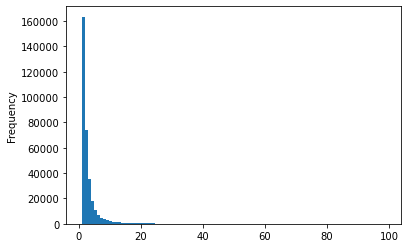

In [76]:
job_count[job_count < 100].plot.hist(bins=100)

In [86]:
job_count[job_count == 3][:3]

bin__
3000889    3
2005885    3
4579819    3
dtype: int64

In [103]:
job.loc[job['bin__'] == '3000889', ['job__', 'job_description', 'building_type', 'other', 'other_description']]

,job__,job_description,building_type,other,other_description
655671,310305336,NaN,OTHERS,X,NO WORK
655889,320548136,"OFFICE RENOVATION: CELLAR, 1ST FLOOR & ROOF: N...",OTHERS,X,GEN. CONSTR.
1041972,301370219,Building Paving Plan filing in conjunction wit...,OTHERS,X,BPP


In [109]:
permit.loc[permit['bin__'] == '3000889', ['job__', 'permit_subtype', 'work_type']]

,job__,permit_subtype,work_type
23702,320548136,MH,MH
214593,320548136,OT,OT


In [100]:
job.loc[655889, 'job_description']

'OFFICE RENOVATION: CELLAR, 1ST FLOOR & ROOF: NEW PARTITIONS, CARPENTRY, FINISHES, NEW SKYLIGHTS, PLUMBING FIXTURES, DUCTWORK.'